In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram

In [2]:
def simon_oracle(b):
    n = len(b)
    circ = QuantumCircuit(2*n, n)

    for i in range(n):
        circ.cx(i, i+n)

    # for i in range(n):
    #     if b[n-1-i] == '1':
    #         for j in range(n):
    #             if b[j] == '1':
    #                 circ.cx(i, j + n)
    #         break
    for i in range(n):
        if b[n-1-i] == '1':
            circ.cx(i, i+n)

    return circ

In [3]:
b = '1001'
n = len(b)

circ = QuantumCircuit(2*n, n)
circ.h(range(n))
circ.barrier()

circ = circ.compose(simon_oracle(b))

circ.barrier()

circ.h(range(n))

circ.measure(range(n), range(n))

In [4]:
print("the coresponding function should saticfy")
b_dex = int(b, base=2)
for num in range(2**(n-1)):
    print(f"f({num}) = f({num ^ b_dex})")

the coresponding function should saticfy
f(0) = f(9)
f(1) = f(8)
f(2) = f(11)
f(3) = f(10)
f(4) = f(13)
f(5) = f(12)
f(6) = f(15)
f(7) = f(14)


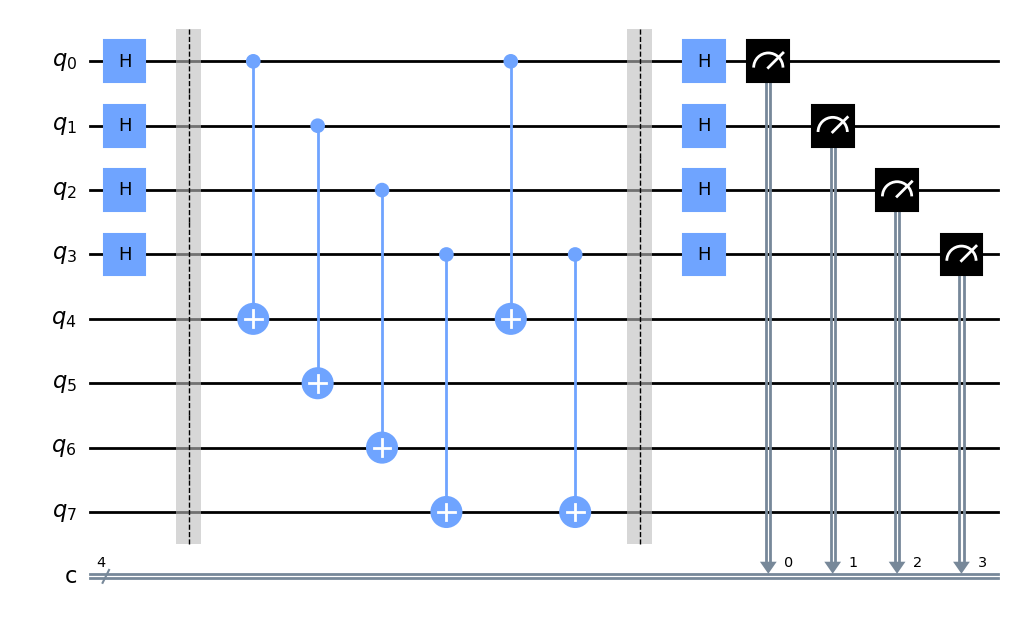

In [5]:
circ.draw('mpl')

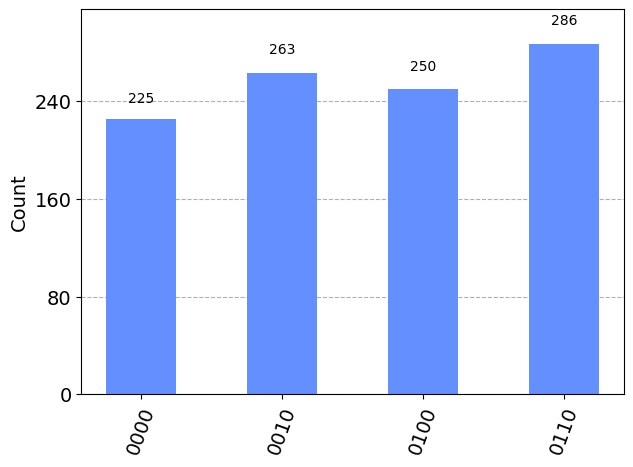

In [6]:
sim = Aer.get_backend("qasm_simulator")
result = execute(circ, backend=sim).result()

plot_histogram(result.get_counts())

In [7]:
#find b

def bdotz(b, z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

In [8]:
shots = 1024
for z in result.get_counts().keys():
    print( '{} . {} = {} (mod 2) ({:.1f}%)'.format(b, z, bdotz(b,z), result.get_counts()[z]*100/shots))

1001 . 0100 = 0 (mod 2) (24.4%)
1001 . 0110 = 0 (mod 2) (27.9%)
1001 . 0000 = 0 (mod 2) (22.0%)
1001 . 0010 = 0 (mod 2) (25.7%)


Transpiling


In [9]:
import random
import timeit
import matplotlib.colors as mcolors
from backend_operation import run_simulator, get_transpiled_circuits_of_circuit, get_fake_backend_list,get_unitary, get_fake_backend, get_fake_backend_list
from itertools import combinations, permutations

In [10]:
fake_backed_name = 'FakeAuckland'

In [12]:
transpiled_circuit = get_transpiled_circuits_of_circuit(circ, ['Aer', fake_backed_name], 
                                                    [None, "Full_Range"],
                                                    optimization_level_list=[0,3])

result_for_circuiut =  [
        run_simulator(qc,shots = 1024 * 4)
        for qc in transpiled_circuit   
]


output = []
for index, run_circuit in enumerate(result_for_circuiut): 
    result_dict= run_circuit.to_dict()
    cirq_result = result_dict['results'][0]
    cirq_counts = cirq_result['data']['counts']
    cirq_time = cirq_result['time_taken']
    cirq_name = cirq_result['header']['name']
    cirq_depth = transpiled_circuit[index].depth()
    output.append({'name' : cirq_name, 'time_taken' :cirq_time, 'depth':cirq_depth, 'count':cirq_counts})

print(output)

[{'name': 'Aer | None | 0', 'time_taken': 0.0138674, 'depth': 5, 'count': {'0x4': 1059, '0x0': 964, '0x6': 1047, '0x2': 1026}}, {'name': 'Aer | None | 3', 'time_taken': 0.0141444, 'depth': 4, 'count': {'0x4': 1022, '0x6': 1001, '0x2': 1039, '0x0': 1034}}, {'name': 'Aer | Full_Range | 0', 'time_taken': 0.0142333, 'depth': 5, 'count': {'0x4': 1030, '0x0': 1086, '0x2': 989, '0x6': 991}}, {'name': 'Aer | Full_Range | 3', 'time_taken': 0.0139743, 'depth': 4, 'count': {'0x2': 1011, '0x0': 1085, '0x4': 1015, '0x6': 985}}, {'name': 'FakeAuckland | None | 0', 'time_taken': 0.0115541, 'depth': 35, 'count': {'0x2': 1027, '0x4': 977, '0x6': 1035, '0x0': 1057}}, {'name': 'FakeAuckland | None | 3', 'time_taken': 0.008537, 'depth': 7, 'count': {'0x2': 1041, '0x0': 1027, '0x6': 1038, '0x4': 990}}, {'name': 'FakeAuckland | Full_Range | 0', 'time_taken': 0.0092563, 'depth': 39, 'count': {'0x2': 1003, '0x6': 1036, '0x0': 1041, '0x4': 1016}}, {'name': 'FakeAuckland | Full_Range | 3', 'time_taken': 0.00935

In [13]:
import pandas as pd

df = pd.DataFrame(output)
df

,name,time_taken,depth,count
0,Aer | None | 0,0.013867,5,"{'0x4': 1059, '0x0': 964, '0x6': 1047, '0x2': ..."
1,Aer | None | 3,0.014144,4,"{'0x4': 1022, '0x6': 1001, '0x2': 1039, '0x0':..."
2,Aer | Full_Range | 0,0.014233,5,"{'0x4': 1030, '0x0': 1086, '0x2': 989, '0x6': ..."
3,Aer | Full_Range | 3,0.013974,4,"{'0x2': 1011, '0x0': 1085, '0x4': 1015, '0x6':..."
4,FakeAuckland | None | 0,0.011554,35,"{'0x2': 1027, '0x4': 977, '0x6': 1035, '0x0': ..."
5,FakeAuckland | None | 3,0.008537,7,"{'0x2': 1041, '0x0': 1027, '0x6': 1038, '0x4':..."
6,FakeAuckland | Full_Range | 0,0.009256,39,"{'0x2': 1003, '0x6': 1036, '0x0': 1041, '0x4':..."
7,FakeAuckland | Full_Range | 3,0.009352,17,"{'0x0': 1010, '0x6': 998, '0x2': 1011, '0x4': ..."


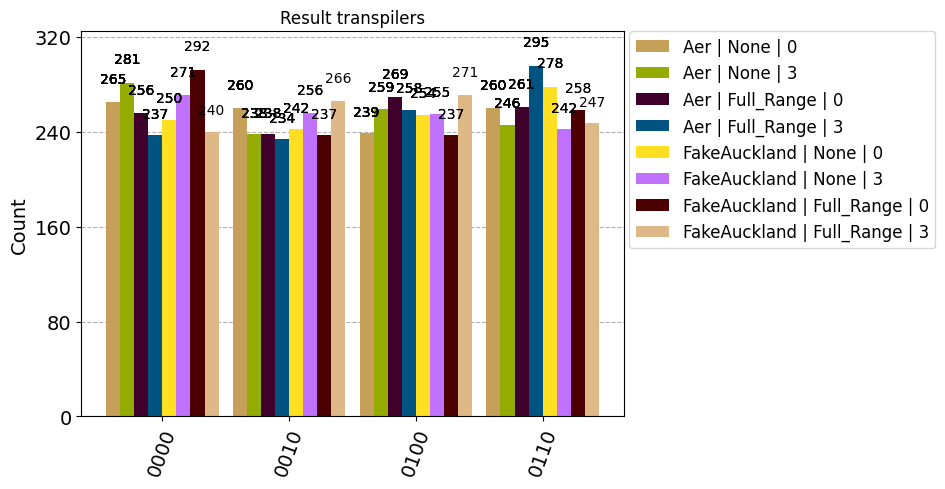

In [14]:
plot_histogram([run_simulator(qc,shots = 1024).get_counts() for qc in transpiled_circuit], 
               legend=[qc.name for qc in transpiled_circuit], color=list(random.choices(list(mcolors.get_named_colors_mapping().values()), k = len(transpiled_circuit))),
               title="Result transpilers")

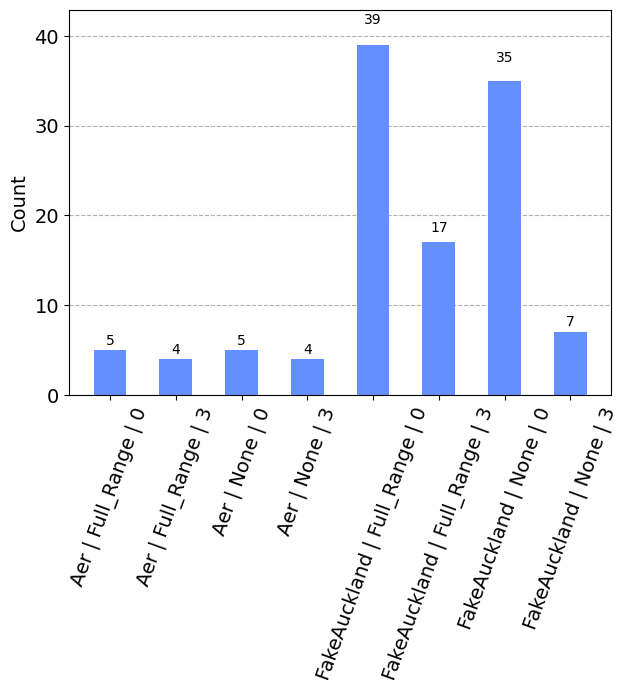

In [16]:
plot_histogram({
    qc.name : qc.depth()
    for qc in transpiled_circuit
})